# Data Analysis Notebook 

This notebook is designed for the purpose of analyzing data obtained from the Hydra cluster. It provides a set of tools and techniques for performing data analysis tasks and extracting insights from the data.


## EE of the Cut for large range of system sizes


In [1]:
Sys.CPU_THREADS

6

In [2]:
using Base.Filesystem  # for creaating directories etc
using Random, Distributions  # random numbers
using HDF5  # hdf5 files
using QuantumClifford  # this is the stabilizer simulation package
using Plots # for plotting
using Formatting # string formatting
using LinearAlgebra # some useful matrices etc.
dep_path = "../AdditionalStructure/Julia/"
include("$(dep_path)NewTypes.jl")
include("$(dep_path)BitStringOps.jl")
include("$(dep_path)Measurements.jl")
include("$(dep_path)MICModels.jl")
include("$(dep_path)ModelRuns.jl")
include("$(dep_path)HelperTools.jl")
include("$(dep_path)Iterators.jl");

exp_index = 15
dir_extension = "_z"
file_prefix = "out/"
filename = "../Remote-Hydra/Toric_Code/data$(dir_extension)/$(file_prefix)TEE_exp:$(exp_index).h5"
data = h5read(filename, "/")

for key in keys(data)
    println("$key: $(data[key])")
end


exp_index: 15
p_b: 0.15
TEE: [3, 2, 2, 2, 1, 2, 2, 2, 1, 2]
p_f: 0.0
L: 30
sys_type: Init_EdgeSquareLattice_KitaevDoNuT
EE_cut: [0 46 55 55 53 56 54 55 54 58 55 54 51 54 56 54 51 52 56 55 54 55 57 52 55 52 55 53 55 54 0; 0 52 54 52 55 55 57 57 57 54 55 55 51 58 56 55 57 57 56 52 55 55 52 55 55 58 58 56 54 53 0; 0 50 50 52 53 54 52 54 53 51 54 55 51 49 51 54 53 52 53 52 52 54 51 54 54 50 52 56 50 48 0; 0 52 58 55 54 57 56 56 56 56 57 52 56 56 57 57 55 57 53 56 52 59 57 57 55 57 54 51 56 57 0; 0 50 52 53 55 56 54 55 51 55 53 51 52 52 55 55 54 54 54 51 54 55 53 54 52 55 54 52 52 50 0; 0 47 49 51 50 51 48 51 49 48 53 52 50 51 55 51 49 52 49 53 52 53 52 51 51 52 51 49 52 46 0; 0 52 51 54 55 57 53 56 55 54 52 53 54 50 54 51 53 55 52 54 56 53 54 56 56 55 52 56 52 52 0; 0 49 49 53 55 52 54 53 55 53 58 54 53 56 55 53 55 56 56 56 55 55 57 54 55 52 54 55 52 52 0; 0 48 52 53 51 52 52 51 51 53 51 53 53 52 46 52 53 52 54 50 50 52 53 52 52 56 49 51 51 50 0; 0 53 52 52 56 54 53 54 57 53 54 53 53 53 57

In [3]:
all_data = []

model_data_dict = Dict()

for exp_index in 1:800
    filename = "../Remote-Hydra/Toric_Code/data$(dir_extension)/$(file_prefix)TEE_exp:$(exp_index).h5"
    if ispath(filename)
        data = h5read(filename, "/")
        # print(data["L"],",")
        push!(all_data, data)
        model_data_dict[(data["L"], data["p_b"], data["p_f"])] = data
    end
end
print("data sets read: ",length(all_data))

all_sizes = sort(collect(keys(model_data_dict)))

data sets read: 16

3-element Vector{Any}:
 (30, 0.0, 0.55)
 (30, 0.15, 0.0)
 (30, 0.21, 0.2)

In [4]:
model_data_dict[(30, 0.15, 0.0)]

Dict{String, Any} with 13 entries:
  "exp_index"       => 393
  "p_b"             => 0.15
  "TEE"             => [3, 2, 3, 3, 3, 3, 3, 2, 3, 2]
  "p_f"             => 0.0
  "L"               => 30
  "sys_type"        => "Init_EdgeSquareLattice_KitaevDoNuT"
  "EE_cut"          => [0 52 … 54 0; 0 54 … 50 0; … ; 0 50 … 48 0; 0 54 … 53 0]
  "t_mmt"           => [70, 90, 110, 130, 150, 170, 190, 210, 230, 250]
  "Fermion_Fermion" => [1 0 … 0 0; 1 0 … 0 0; … ; 1 0 … 0 0; 1 0 … 0 0;;; 0 0 ……
  "Boson_Boson"     => [1 0 … 0 0; 1 0 … 0 0; … ; 1 0 … 0 0; 1 0 … 0 0;;; 0 0 ……
  "filename"        => "/mnt/users/jovanovic/GitHub/Subsystem-Code-Physics/Remo…
  "description"     => "Single Points in the Phase Diagram, Zassenhausen fermi-…
  "d"               => 3

In [5]:
function give_type(data)
    return (data["L"], data["p_b"], data["p_f"])
end

give_type (generic function with 1 method)

In [6]:
CUT_dict_helper = Dict(
    size_key => [] for size_key in keys(model_data_dict)
)

for data in all_data
    size_key = give_type(data)
    push!(CUT_dict_helper[size_key], permutedims(data["EE_cut"],(2,1)))
end

CUT_dict = Dict()

for size_key in all_sizes
    CUT_dict[size_key] = cat(dims= 2, CUT_dict_helper[size_key]...)
end

CUT_means = Dict()
CUT_vars = Dict()
CUT_errs = Dict()
CUT_medians = Dict()

for size_key in all_sizes
    CUT_means[size_key] = mean(CUT_dict[size_key], dims = 2)
    CUT_vars[size_key] = var(CUT_dict[size_key], dims = 2)
    CUT_errs[size_key] = std(CUT_dict[size_key], dims = 2) / sqrt(size(CUT_dict[size_key], 2))
    CUT_medians[size_key] = median(CUT_dict[size_key], dims = 2)
end

CUT_Stats = Dict(
    "mean" => CUT_means,
    "var" => CUT_vars,
    "err" => CUT_errs,
    "median" => CUT_medians
)

Dict{String, Dict{Any, Any}} with 4 entries:
  "median" => Dict((30, 0.21, 0.2)=>[0.0; 35.5; … ; 36.0; 0.0;;], (30, 0.0, 0.5…
  "err"    => Dict((30, 0.21, 0.2)=>[0.0; 0.554064; … ; 0.581008; 0.0;;], (30, …
  "mean"   => Dict((30, 0.21, 0.2)=>[0.0; 35.7667; … ; 35.5; 0.0;;], (30, 0.0, …
  "var"    => Dict((30, 0.21, 0.2)=>[0.0; 18.4192; … ; 20.2542; 0.0;;], (30, 0.…

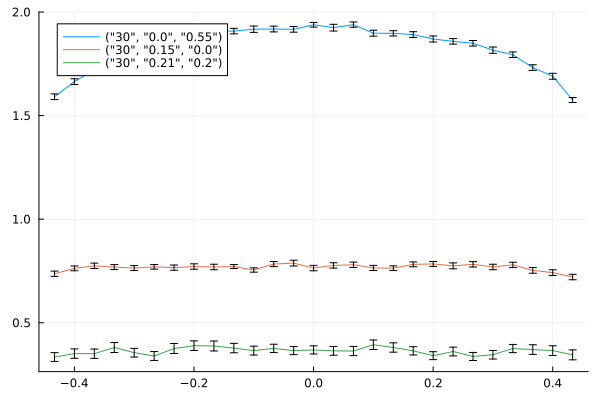

In [16]:
stat = "mean"
ribbon = "err"


plot()
for size_key in all_sizes
    L, p_b, p_f = size_key
    x_axis = get_subdiv_array(L, "all") .- L/2
    x_axis = x_axis[3:end-2]
    x_axis = x_axis./L
    y_axis = CUT_Stats[stat][size_key][3:end-2] .- L # SAGE to inform which subleading term to cancel
    volume_scale = L^2
    area_scale = L
    critical_scale = L*log2(L)
    scale = area_scale
    y_axis = y_axis./scale
    y_err = CUT_Stats[ribbon][size_key][3:end-2]
    y_err = y_err./scale 
    plot!(x_axis, y_axis, yerror = y_err, label = size_key)
end

plot!()

In [14]:
TEE_dict_helper = Dict(
    size_key => [] for size_key in keys(model_data_dict)
)

for data in all_data
    size_key = give_type(data)
    push!(TEE_dict_helper[size_key], data["TEE"])
end

TEE_dict = Dict()

for size_key in all_sizes
    TEE_dict[size_key] = cat(dims= 1, TEE_dict_helper[size_key]...)
end

TEE_means = Dict()
TEE_vars = Dict()
TEE_errs = Dict()
TEE_medians = Dict()

for size_key in all_sizes
    TEE_means[size_key] = mean(TEE_dict[size_key], dims = 1)
    TEE_vars[size_key] = var(TEE_dict[size_key], dims = 1)
    TEE_errs[size_key] = std(TEE_dict[size_key], dims = 1) / sqrt(size(TEE_dict[size_key], 1))
    TEE_medians[size_key] = median(TEE_dict[size_key], dims = 1)
end

TEE_Stats = Dict(
    "mean" => TEE_means,
    "var" => TEE_vars,
    "err" => TEE_errs,
    "median" => TEE_medians
)

Dict{String, Dict{Any, Any}} with 4 entries:
  "median" => Dict((30, 0.21, 0.2)=>[0.0], (30, 0.0, 0.55)=>[1.0], (30, 0.15, 0…
  "err"    => Dict((30, 0.21, 0.2)=>[0.0], (30, 0.0, 0.55)=>[0.107514], (30, 0.…
  "mean"   => Dict((30, 0.21, 0.2)=>[0.0], (30, 0.0, 0.55)=>[1.56], (30, 0.15, …
  "var"    => Dict((30, 0.21, 0.2)=>[0.0], (30, 0.0, 0.55)=>[0.577959], (30, 0.…

In [15]:
TEE_Stats["mean"]

Dict{Any, Any} with 3 entries:
  (30, 0.21, 0.2) => [0.0]
  (30, 0.0, 0.55) => [1.56]
  (30, 0.15, 0.0) => [2.24]

In [8]:
function add_corr_data!(corr_dic, corr_table, L, metric = taxi_metrix_torus)
    
    if length(corr_dic) == 0
        all_r = []
        for i = 1:L
            for j = 1:L
                x_i = i - 1
                y_i = j - 1
                push!(all_r, metric((0, 0), (x_i, y_i), L, L))
            end
        end
        
        for r in all_r
            corr_dic[r] = []
        end
    end # Creates a dictionary keys if corr_dic is empty. The arrays are still empty.

    for i = 1:L
        for j = 1:L
            x_i = i - 1
            y_i = j - 1
            r = metric((0, 0), (x_i, y_i), L, L)
            push!(corr_dic[r], corr_table[i, j])
        end
    end

    return corr_dic
end

function get_corr_stats(corr_dic)

    r_s = sort(collect(keys(corr_dic)))

    corr_stats = Dict(
        "x_axis" => r_s,
        "mean" => [mean(corr_dic[r]) for r in r_s],
        "median" => [median(corr_dic[r]) for r in r_s],
        "var" => [var(corr_dic[r]) for r in r_s],
        "err" => [std(corr_dic[r]) / sqrt(length(corr_dic[r])) for r in r_s]
    )

    return corr_stats
end

get_corr_stats (generic function with 1 method)

In [9]:
FF_dict_all = Dict()

for data in all_data
    FF_dict_all[give_type(data)] = Dict()
end

for data in all_data
    L, p_b, p_f = give_type(data)
    t_mmt = data["t_mmt"]
    for i_t = 1:length(t_mmt)
        add_corr_data!(FF_dict_all[(L, p_b, p_f)], data["Fermion_Fermion"][i_t, :, :], L)
    end
end

FF_stats = Dict()

for key in keys(FF_dict_all)
    FF_stats[key] = get_corr_stats(FF_dict_all[key])
end

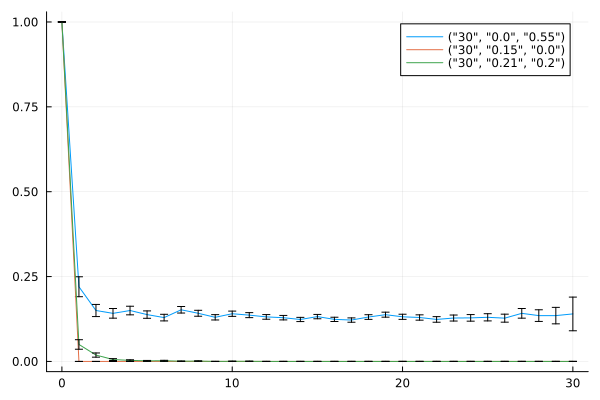

In [10]:
stat = "mean"
ribbon = "err"

plot()

for size_key in all_sizes
    L, p_b, p_f = size_key
    x_axis = FF_stats[size_key]["x_axis"]
    y_axis = FF_stats[size_key][stat]
    y_err = FF_stats[size_key][ribbon]
    plot!(x_axis, y_axis, yerror = y_err, label = size_key)
end

plot!()

In [11]:
BB_dict_all = Dict()

for data in all_data
    BB_dict_all[give_type(data)] = Dict()
end

for data in all_data
    L, p_b, p_f = give_type(data)
    t_mmt = data["t_mmt"]
    for i_t = 1:length(t_mmt)
        add_corr_data!(BB_dict_all[(L, p_b, p_f)], data["Boson_Boson"][i_t, :, :], L)
    end
end

BB_stats = Dict()

for key in keys(BB_dict_all)
    BB_stats[key] = get_corr_stats(BB_dict_all[key])
end

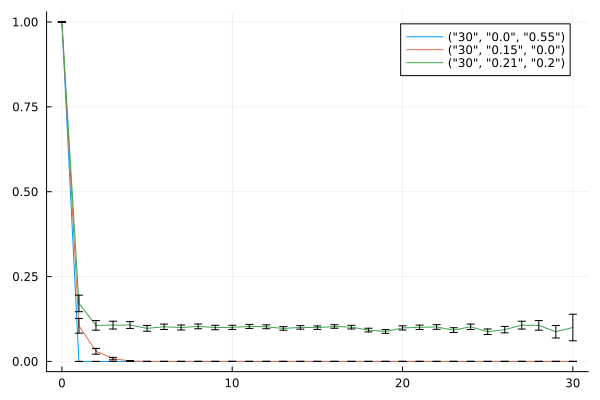

In [12]:
stat = "mean"
ribbon = "err"

plot()

for size_key in all_sizes
    L, p_b, p_f = size_key
    x_axis = BB_stats[size_key]["x_axis"]
    y_axis = BB_stats[size_key][stat]
    y_err = BB_stats[size_key][ribbon]
    plot!(x_axis, y_axis, yerror = y_err, label = size_key)
end

plot!()